In [117]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

#Set the seed for reproducibility
np.random.seed(7)

## Import Dataset & Data Preparation

In [118]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


## Define Environment

In [119]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()
        
        # Set the seed for reproducibility
        self.seed_value = 7
        np.random.seed(self.seed_value)
        
        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = gym.spaces.Discrete(51, start=-25) 
        self.time_constraint = 6
        self.battery_time_constraint = 20
        self.initialize_params()

    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_battery = 20
        self.available = True
        self.current_state = tuple([self.current_hour, int(self.current_battery < 20)])
        self.state_space = [24, 2, self.action_space.n]
        self.done = False
        self.profit = 0 
        
    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5 
        else:
            available = True
        return available
    
    def update_state(self):
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            #print('Car unavailable')
            self.current_hour = 17
            self.current_battery -= 20
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
                
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        # Update time step and hour
            
        self.current_state = tuple([self.current_hour, int(self.current_battery < 20)])   

        # Update state
        # Check if the episode is done (after 3 years of past electricity prices)
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
    def to_discrete(self, action):
        mask = np.zeros(self.action_space.n, dtype=np.int8)
        mask[action] = 1
        return self.action_space.sample(mask = mask)

    def reward(self, action, charge_cost):
        reward = -charge_cost
        return reward
        
    def step(self, action):
        self.available=self.car_available()
        
        # discretize action
        if self.available == True:
            action = self.to_discrete(action) 
        else:
             action = 0
        
        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action* 2 
        charge_cost *= energy_rate / 1000
        
        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
        self.current_battery += actual_charge
        
        # update variables
        self.profit += -charge_cost

        # reward
        reward = self.reward(action, charge_cost)
        
        self.update_state()
        return self.current_state, reward, self.done, self.available

## Define QAgent

In [120]:
class QAgent():
    def __init__(self, env, discount_rate = 0.9, learning_rate=0.1, epsilon=0.05):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 7 am constraint  
        if self.env.current_hour == self.env.time_constraint and self.env.current_battery >= self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)*0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.current_hour == self.env.time_constraint and self.env.current_battery < self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)/0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.current_battery)*0.9), -self.env.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        
        #print(f" battery: {self.env.current_battery}, time: {self.env.current_hour+1}, range: {mask_range}")
        
        # construct boolean mask_vector
        mask = np.arange(self.env.action_space.start, self.env.action_space.start + self.env.action_space.n)
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()
        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(np.arange(env.action_space.n)[mask])
        
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        
        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            while not self.env.done:    
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()

                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta   
            self.profit.append(env.profit)
            self.env.initialize_params()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action

    def predict_random(self, state):
        mask = self.mask()
        action = np.random.choice(np.where(mask)[0])
        return action
    
    def buy_sell_based_on_price(self):
        mask = self.mask()
        
        # Calculate the average price of the last month
        lw_bound = max(0, self.env.current_step-30)
        avg_price_last_month = np.mean(self.env.price_data.iloc[lw_bound:self.env.current_step, 0:24])

        # Decide whether to buy or sell based on the current price compared to the average
        current_price = self.env.price_data.iloc[self.env.current_step, self.env.current_hour]
        #print(f"Current Price: {current_price}, Avg Price: {avg_price_last_month}")
        
        actionValues = np.arange(0, 51)
        valid_action = actionValues[mask]
        
        if not np.isnan(avg_price_last_month):      
            if current_price < avg_price_last_month:
                action = valid_action[valid_action > 25]
                action = np.random.choice(action) if len(action) > 0 else 25
            else:
                action = valid_action[valid_action < 25]
                action = np.random.choice(action) if len(action) > 0 else 25
        else:
            action = 25
        return action 
    
    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')
        plt.ylabel('Profit')
        plt.title("Cost per epoch")

## Train QAgent

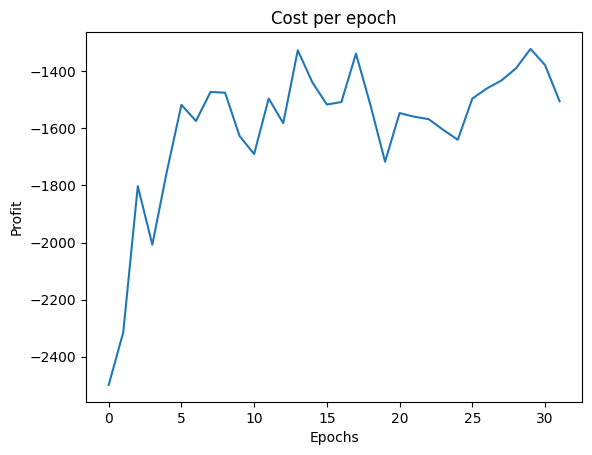

In [121]:
env = SmartGridEnv(train)
agent = QAgent(env)
agent.train(simulations=32)
agent.plot_profits()

## Eval QAgent

In [122]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print(f"Profit on validation set: {eval_env.profit:.2f}")

at time 1 agent transacts -18 KWh, battery is 20
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 a

at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 ag

at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 age

at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agen

at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent

at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agen

at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent t

at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 a

at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 age

at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 ag

at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agen

at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agen

at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agen

at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 ag

at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agen

at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agen

at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agen

at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agen

at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agen

at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agen

at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 ag

at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent tran

at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent

at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 agent transacts 0 KWh, battery is 0
at time 4 agent transacts 0 KWh, battery is 0
at time 5 agent transacts 0 KWh, battery is 0
at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 a

at time 6 agent transacts 12 KWh, battery is 0
at time 7 agent transacts 10 KWh, battery is 11
at time 8 agent transacts -10 KWh, battery is 20
at time 9 agent transacts -8 KWh, battery is 9
at time 10 agent transacts 0 KWh, battery is 0
at time 11 agent transacts 0 KWh, battery is 0
at time 12 agent transacts 0 KWh, battery is 0
at time 13 agent transacts 0 KWh, battery is 0
at time 14 agent transacts 0 KWh, battery is 0
at time 15 agent transacts 0 KWh, battery is 0
at time 16 agent transacts 0 KWh, battery is 0
at time 17 agent transacts 0 KWh, battery is 0
at time 18 agent transacts 0 KWh, battery is 0
at time 19 agent transacts 0 KWh, battery is 0
at time 20 agent transacts 0 KWh, battery is 0
at time 21 agent transacts 0 KWh, battery is 0
at time 22 agent transacts 0 KWh, battery is 0
at time 23 agent transacts 0 KWh, battery is 0
at time 24 agent transacts 0 KWh, battery is 0
at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 0 KWh, battery is 0
at time 3 ag

### Eval Baseline models

#### Random Baseline

In [123]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict_random(current_state)
    next_state, reward, done, available = agent.env.step(action)

print(f"Profit on validation set: {eval_env.profit:.2f}")

Profit on validation set: -5195.23


#### 30-day Moving Average Baseline

In [124]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.buy_sell_based_on_price()
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} kWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print(f"Profit on validation set: {eval_env.profit:.2f}")

at time 1 agent transacts 0 kWh, battery is 20
at time 2 agent transacts 0 kWh, battery is 20
at time 3 agent transacts 0 kWh, battery is 20
at time 4 agent transacts 0 kWh, battery is 20
at time 5 agent transacts 0 kWh, battery is 20
at time 6 agent transacts 0 kWh, battery is 20
at time 7 agent transacts 0 kWh, battery is 20
at time 8 agent transacts 0 kWh, battery is 20
at time 9 agent transacts 0 kWh, battery is 20
at time 10 agent transacts 0 kWh, battery is 20
at time 11 agent transacts 0 kWh, battery is 20
at time 12 agent transacts 0 kWh, battery is 20
at time 13 agent transacts 0 kWh, battery is 20
at time 14 agent transacts 0 kWh, battery is 20
at time 15 agent transacts 0 kWh, battery is 20
at time 16 agent transacts 0 kWh, battery is 20
at time 17 agent transacts 0 kWh, battery is 20
at time 18 agent transacts 0 kWh, battery is 20
at time 19 agent transacts 0 kWh, battery is 20
at time 20 agent transacts 0 kWh, battery is 20
at time 21 agent transacts 0 kWh, battery is 20
a

at time 21 agent transacts 6 kWh, battery is 38
at time 22 agent transacts 2 kWh, battery is 43
at time 23 agent transacts 1 kWh, battery is 45
at time 24 agent transacts 1 kWh, battery is 46
at time 1 agent transacts 3 kWh, battery is 47
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 9 agent transacts 0 kWh, battery is 50
at time 10 agent transacts 0 kWh, battery is 50
at time 11 agent transacts 0 kWh, battery is 50
at time 12 agent transacts 0 kWh, battery is 50
at time 13 agent transacts 0 kWh, battery is 50
at time 14 agent transacts 0 kWh, battery is 50
at time 15 agent transacts 0 kWh, battery is 50
at time 16 agent transacts 0 kWh, battery is 50
at time 17 agent transacts 0 kWh, battery is 50
a

at time 19 agent transacts -5 kWh, battery is 6
at time 20 agent transacts 0 kWh, battery is 0
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 10 kWh, battery is 0
at time 23 agent transacts 20 kWh, battery is 9
at time 24 agent transacts 12 kWh, battery is 27
at time 1 agent transacts 3 kWh, battery is 38
at time 2 agent transacts 5 kWh, battery is 41
at time 3 agent transacts 3 kWh, battery is 45
at time 4 agent transacts 2 kWh, battery is 48
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -17 kWh, battery is 50
at time 18 agent transacts -5 kWh, battery is 30
at time 19 agent transacts -5 kWh, battery is 24
at time 20 agent transacts -6 kWh, battery is 18
at time 21 agent transacts -9 kWh, battery is 11
at time 22 agent transacts 14 kWh, battery is 1
at time 23 agent transacts 3 kWh, battery is 14
at time 24 agent transacts 23 kWh, battery 

at time 19 agent transacts -5 kWh, battery is 7
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 12 kWh, battery is 1
at time 22 agent transacts 6 kWh, battery is 12
at time 23 agent transacts 4 kWh, battery is 17
at time 24 agent transacts 14 kWh, battery is 21
at time 1 agent transacts 6 kWh, battery is 34
at time 2 agent transacts 9 kWh, battery is 39
at time 3 agent transacts 3 kWh, battery is 47
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 13 kWh, battery is 30
at time 19 agent transacts -1 kWh, battery is 42
at time 20 agent transacts 6 kWh, battery is 41
at time 21 agent transacts 1 kWh, battery is 46
at time 22 agent transacts 1 kWh, battery is 47
at time 23 agent transacts 2 kWh, battery is 48
at time 24 agent transacts 0 kWh, battery is 5

at time 24 agent transacts 15 kWh, battery is 1
at time 1 agent transacts 3 kWh, battery is 15
at time 2 agent transacts 10 kWh, battery is 18
at time 3 agent transacts 12 kWh, battery is 27
at time 4 agent transacts 7 kWh, battery is 38
at time 5 agent transacts 2 kWh, battery is 44
at time 6 agent transacts 2 kWh, battery is 46
at time 7 agent transacts -24 kWh, battery is 48
at time 8 agent transacts -16 kWh, battery is 21
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 6 kWh, battery is 1
at time 2 agent transacts 16 kWh, battery is 6
at time 3 agent transacts 7 kWh, battery is 20
at time 4 agent transacts 19 kWh, battery is 26
at time 5 agent transacts 7 kWh, battery is 43
at tim

at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -1 kWh, battery is 50
at time 9 agent transacts -1 kWh, battery is 49
at time 10 agent transacts -1 kWh, battery is 48
at time 11 agent transacts -16 kWh, battery is 47
at time 12 agent transacts -15 kWh, battery is 29
at time 13 agent transacts -2 kWh, battery is 12
at time 14 agent transacts -6 kWh, battery is 10
at time 15 agent transacts 16 kWh, battery is 3
at time 16 agent transacts 11 kWh, battery is 17
at time 17 agent transacts 2 kWh, battery is 27
at time 18 agent transacts 11 kWh, battery is 29
at time 19 agent transacts -15 kWh, battery is 39
at time 20 agent transacts -3 kWh, battery is 22
at time 21 agent transacts -5 kWh, battery is 19
at time 22 agent transacts 18 kWh, battery is 13
at time 23 agent transacts 9 kWh, battery is 29
at time 24 agent transacts 12 kWh, battery is 37
at time 1 agent transacts 1 

at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 10 kWh, battery is 1
at time 2 agent transacts 15 kWh, battery is 10
at time 3 agent transacts 14 kWh, battery is 24
at time 4 agent transacts 10 kWh, battery is 37
at time 5 agent transacts 1 kWh, battery is 46
at time 6 agent transacts 1 kWh, battery is 47
at time 7 agent transacts -19 kWh, battery is 48
at time 8 agent transacts -4 kWh, battery is 27
at time 18 agent transacts 21 kWh, battery is 7
at time 19 agent transacts -15 kWh, battery is 26
at time 20 agent transacts -8 kWh, battery is 9
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 0 kWh, battery is 0
at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 1 kWh, battery is 0
at time 1 agent transacts 4 kWh, battery is 1
at time 2 agent transacts 22 kWh, battery is 5
at time 3 agent transacts 6 kWh, battery is 25
at 

at time 19 agent transacts 23 kWh, battery is 22
at time 20 agent transacts 7 kWh, battery is 43
at time 21 agent transacts -20 kWh, battery is 49
at time 22 agent transacts -1 kWh, battery is 27
at time 23 agent transacts -23 kWh, battery is 26
at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 12 kWh, battery is 0
at time 2 agent transacts 14 kWh, battery is 11
at time 3 agent transacts 11 kWh, battery is 24
at time 4 agent transacts 5 kWh, battery is 34
at time 5 agent transacts 11 kWh, battery is 38
at time 6 agent transacts 1 kWh, battery is 48
at time 7 agent transacts 1 kWh, battery is 49
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 16 kWh, battery is 30
at time 19 agent transacts 6 kWh, battery is 44
at time 20 agent transacts 1 kWh, battery is 49
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts -1 kWh, battery is 50
at time 23 agent transacts 1 kWh, battery is 49
at time 24 agent transacts 0 kWh, batt

at time 14 agent transacts 24 kWh, battery is 10
at time 15 agent transacts 12 kWh, battery is 32
at time 16 agent transacts 2 kWh, battery is 43
at time 17 agent transacts 4 kWh, battery is 45
at time 18 agent transacts 1 kWh, battery is 49
at time 19 agent transacts 0 kWh, battery is 50
at time 20 agent transacts -11 kWh, battery is 50
at time 21 agent transacts -12 kWh, battery is 38
at time 22 agent transacts -12 kWh, battery is 25
at time 23 agent transacts -8 kWh, battery is 12
at time 24 agent transacts -1 kWh, battery is 3
at time 1 agent transacts 11 kWh, battery is 2
at time 2 agent transacts 25 kWh, battery is 12
at time 3 agent transacts 4 kWh, battery is 34
at time 4 agent transacts 5 kWh, battery is 38
at time 5 agent transacts 1 kWh, battery is 42
at time 6 agent transacts 3 kWh, battery is 43
at time 7 agent transacts -1 kWh, battery is 46
at time 8 agent transacts -25 kWh, battery is 45
at time 18 agent transacts -9 kWh, battery is 25
at time 19 agent transacts -6 kWh,

at time 2 agent transacts 2 kWh, battery is 44
at time 3 agent transacts 1 kWh, battery is 46
at time 4 agent transacts 2 kWh, battery is 47
at time 5 agent transacts 1 kWh, battery is 49
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 3 kWh, battery is 30
at time 19 agent transacts 18 kWh, battery is 33
at time 20 agent transacts 1 kWh, battery is 49
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts 0 kWh, battery is 50
at time 23 agent transacts -8 kWh, battery is 50
at time 24 agent transacts 10 kWh, battery is 41
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at 

at time 3 agent transacts 3 kWh, battery is 41
at time 4 agent transacts 3 kWh, battery is 44
at time 5 agent transacts 2 kWh, battery is 47
at time 6 agent transacts 1 kWh, battery is 49
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -2 kWh, battery is 50
at time 9 agent transacts -16 kWh, battery is 48
at time 10 agent transacts -23 kWh, battery is 30
at time 11 agent transacts -1 kWh, battery is 4
at time 12 agent transacts -1 kWh, battery is 3
at time 13 agent transacts -1 kWh, battery is 2
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at t

at time 13 agent transacts -4 kWh, battery is 10
at time 14 agent transacts -5 kWh, battery is 6
at time 15 agent transacts 0 kWh, battery is 0
at time 16 agent transacts 0 kWh, battery is 0
at time 17 agent transacts 0 kWh, battery is 0
at time 18 agent transacts 0 kWh, battery is 0
at time 19 agent transacts 0 kWh, battery is 0
at time 20 agent transacts 0 kWh, battery is 0
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 0 kWh, battery is 0
at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 2 kWh, battery is 0
at time 2 agent transacts 13 kWh, battery is 2
at time 3 agent transacts 11 kWh, battery is 14
at time 4 agent transacts 11 kWh, battery is 24
at time 5 agent transacts 11 kWh, battery is 34
at time 6 agent transacts 4 kWh, battery is 44
at time 7 agent transacts 1 kWh, battery is 48
at time 8 agent transacts -18 kWh, battery is 49
at time 9 agent transacts -22 kWh, battery is 29
at t

at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent transacts 14 kWh, battery is 1
at time 3 agent transacts 14 kWh, battery is 14
at time 4 agent transacts 24 kWh, battery is 27
at time 5 agent transacts 1 kWh, battery is 49
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -19 kWh, battery is 50
at time 9 agent transacts -23 kWh, battery is 29
at time 10 agent transacts -1 kWh, battery is 3
at time 11 agent transacts -1 kWh, battery is 2
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at tim

at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 17 kWh, battery is 30
at time 19 agent transacts 2 kWh, battery is 45
at time 20 agent transacts 2 kWh, battery is 47
at time 21 agent transacts 1 kWh, battery is 49
at time 22 agent transacts 0 kWh, battery is 50
at time 23 agent transacts 0 kWh, battery is 50
at time 24 agent transacts 0 kWh, battery is 50
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 1 kWh, battery is 30
at time 19 agent transacts 3 kWh, battery is 31
at time 20 agent transacts 1 kWh, battery is 34
at

at time 5 agent transacts 1 kWh, battery is 45
at time 6 agent transacts 1 kWh, battery is 46
at time 7 agent transacts 3 kWh, battery is 47
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts -17 kWh, battery is 30
at time 19 agent transacts -4 kWh, battery is 11
at time 20 agent transacts -4 kWh, battery is 7
at time 21 agent transacts 15 kWh, battery is 3
at time 22 agent transacts -4 kWh, battery is 17
at time 23 agent transacts -8 kWh, battery is 13
at time 24 agent transacts -2 kWh, battery is 4
at time 1 agent transacts 18 kWh, battery is 2
at time 2 agent transacts 24 kWh, battery is 18
at time 3 agent transacts 5 kWh, battery is 40
at time 4 agent transacts 5 kWh, battery is 44
at time 5 agent transacts 2 kWh, battery is 48
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 9 agent transacts -22 kWh, battery is 50
at time 10 agent transacts -12 kWh, battery i

at time 8 agent transacts -20 kWh, battery is 31
at time 9 agent transacts -4 kWh, battery is 9
at time 10 agent transacts -3 kWh, battery is 5
at time 11 agent transacts -1 kWh, battery is 2
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 6 kWh, battery is 1
at time 4 agent transacts 6 kWh, battery is 6
at time 5 age

at time 2 agent transacts 22 kWh, battery is 9
at time 3 agent transacts 19 kWh, battery is 29
at time 4 agent transacts 2 kWh, battery is 46
at time 5 agent transacts 2 kWh, battery is 48
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts -6 kWh, battery is 50
at time 8 agent transacts -4 kWh, battery is 43
at time 18 agent transacts -12 kWh, battery is 23
at time 19 agent transacts -9 kWh, battery is 10
at time 20 agent transacts 0 kWh, battery is 0
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 0 kWh, battery is 0
at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 16 kWh, battery is 0
at time 2 agent transacts 13 kWh, battery is 14
at time 3 agent transacts 3 kWh, battery is 26
at time 4 agent transacts 8 kWh, battery is 29
at time 5 agent transacts 5 kWh, battery is 36
at time 6 agent transacts 10 kWh, battery is 40
at time 7 agent transacts -11 kWh, battery is 49
a

at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 13 kWh, battery is 0
at time 2 agent transacts 11 kWh, battery is 12
at time 3 agent transacts 13 kWh, battery is 22
at time 4 agent transacts 14 kWh, battery is 34
at time 5 agent transacts 1 kWh, battery is 47
at time 6 agent transacts 2 kWh, battery is 48
at time 7 agent transacts -8 kWh, battery is 50
at time 8 agent transacts -10 kWh, battery is 41
at time 18 agent transacts -14 kWh, battery is 21
at time 19 agent transacts -1 kWh, battery is 5
at time 20 agent transacts -1 kWh, battery is 4
at time 21 agent transacts -2 kWh, battery is 3
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 6 kWh, battery is 1
at time 2 agent transacts 20 kWh, battery is 6
at time 3 agent transacts 20 kWh, battery is 24
at time 4 agent transacts 4 kWh, battery is 42
a

at time 6 agent transacts 1 kWh, battery is 49
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 9 agent transacts 0 kWh, battery is 50
at time 10 agent transacts 0 kWh, battery is 50
at time 11 agent transacts -20 kWh, battery is 50
at time 12 agent transacts -13 kWh, battery is 28
at time 13 agent transacts -1 kWh, battery is 14
at time 14 agent transacts 11 kWh, battery is 13
at time 15 agent transacts 11 kWh, battery is 23
at time 16 agent transacts 14 kWh, battery is 33
at time 17 agent transacts 1 kWh, battery is 46
at time 18 agent transacts 2 kWh, battery is 47
at time 19 agent transacts -20 kWh, battery is 49
at time 20 agent transacts -1 kWh, battery is 27
at time 21 agent transacts -3 kWh, battery is 26
at time 22 agent transacts -20 kWh, battery is 23
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 22 kWh, battery is 1
at time 2 agent transacts 4 kWh, 

at time 24 agent transacts 12 kWh, battery is 37
at time 1 agent transacts 1 kWh, battery is 48
at time 2 agent transacts 1 kWh, battery is 49
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -11 kWh, battery is 50
at time 9 agent transacts -15 kWh, battery is 38
at time 10 agent transacts -7 kWh, battery is 21
at time 11 agent transacts -6 kWh, battery is 13
at time 12 agent transacts -1 kWh, battery is 6
at time 13 agent transacts -1 kWh, battery is 5
at time 14 agent transacts -3 kWh, battery is 4
at time 15 agent transacts 6 kWh, battery is 1
at time 16 agent transacts 18 kWh, battery is 6
at time 17 agent transacts 7 kWh, battery is 22
at time 18 agent transacts -1 kWh, battery is 28
at time 19 agent transacts -7 kWh, battery is 27
at time 20 agent transacts -5 kWh, batter

at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -7 kWh, battery is 50
at time 18 agent transacts -12 kWh, battery is 30
at time 19 agent transacts -10 kWh, battery is 17
at time 20 agent transacts -2 kWh, battery is 6
at time 21 agent transacts -2 kWh, battery is 4
at time 22 agent transacts 21 kWh, battery is 2
at time 23 agent transacts 3 kWh, battery is 21
at time 24 agent transacts 1 kWh, battery is 24
at time 1 agent transacts 24 kWh, battery is 25
at time 2 agent transacts 3 kWh, battery is 47
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts -3 kWh, battery is 30
at time 19 agent transacts -3 kWh, battery is

at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 6 kWh, battery is 1
at time 4 agent transacts 2 kWh, battery is 6
at time 5 agent transacts 16 kWh, battery is 8
at time 6 agent transacts 12 kWh, battery is 22
at time 7 agent transacts -11 kWh, battery is 33
at time 8 agent transacts -15 kWh, battery is 21
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 24 kWh, battery is 1
at time 2 agent transacts 24 kWh, battery is 23
at time 3 agent transacts 1 kWh, battery is 45
at time 4 agent transacts 4 kWh, battery is 46
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts -16 kWh, battery is 50
at time 

at time 1 agent transacts 25 kWh, battery is 5
at time 2 agent transacts 7 kWh, battery is 27
at time 3 agent transacts 11 kWh, battery is 33
at time 4 agent transacts 5 kWh, battery is 43
at time 5 agent transacts 1 kWh, battery is 47
at time 6 agent transacts 1 kWh, battery is 48
at time 7 agent transacts 1 kWh, battery is 49
at time 8 agent transacts -23 kWh, battery is 50
at time 9 agent transacts -8 kWh, battery is 24
at time 10 agent transacts -5 kWh, battery is 15
at time 11 agent transacts -1 kWh, battery is 9
at time 12 agent transacts -4 kWh, battery is 8
at time 13 agent transacts -2 kWh, battery is 4
at time 14 agent transacts -1 kWh, battery is 2
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at 

at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 12 kWh, battery is 1
at time 17 agent transacts 6 kWh, battery is 12
at time 18 agent transacts -12 kWh, battery is 17
at time 19 agent transacts -3 kWh, battery is 4
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 1 kWh, battery is 1
at time 23 agent transacts 8 kWh, battery is 2
at time 24 agent transacts 8 kWh, battery is 9
at time 1 agent transacts 20 kWh, battery is 16
at time 2 agent transacts 14 kWh, battery is 34
at time 3 agent transacts 1 kWh, battery is 47
at time 4 agent transacts 2 kWh, battery is 48
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -11 kWh, battery is 50
at 

at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 10 kWh, battery is 1
at time 4 agent transacts 3 kWh, battery is 10
at time 5 agent transacts 9 kWh, battery is 13
at time 6 agent transacts 8 kWh, battery is 21
at time 7 agent transacts 8 kWh, battery is 28
at time 8 agent transacts 12 kWh, battery is 35
at time 18 agent transacts -9 kWh, battery is 15
at time 19 agent transacts -2 kWh, battery is 5
at time 20 agent transacts -2 kWh, battery is 3
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 25 kWh, battery is 1
at time 2 agent transacts 21 kWh, battery is 23
at time 3 agent transacts 4 kWh, battery is 42
at time 4 agent transacts 1 kWh, battery is 46
at time 5 agent transacts 2 kWh, battery is 47
at time 6

at time 18 agent transacts -23 kWh, battery is 30
at time 19 agent transacts -3 kWh, battery is 4
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 2 kWh, battery is 1
at time 23 agent transacts -2 kWh, battery is 3
at time 24 agent transacts 25 kWh, battery is 1
at time 1 agent transacts 9 kWh, battery is 23
at time 2 agent transacts 3 kWh, battery is 31
at time 3 agent transacts 9 kWh, battery is 34
at time 4 agent transacts 4 kWh, battery is 42
at time 5 agent transacts 2 kWh, battery is 46
at time 6 agent transacts 2 kWh, battery is 48
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -20 kWh, battery is 50
at time 9 agent transacts -23 kWh, battery is 28
at time 10 agent transacts -1 kWh, battery is 2
at time 11 agent transacts 0 kWh, battery is 1
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at

at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 21 kWh, battery is 1
at time 23 agent transacts 14 kWh, battery is 20
at time 24 agent transacts 5 kWh, battery is 33
at time 1 agent transacts 5 kWh, battery is 37
at time 2 agent transacts 9 kWh, battery is 41
at time 3 agent transacts 1 kWh, battery is 49
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 9 kWh, battery is 30
at time 19 agent transacts -2 kWh, battery is 38
at time 20 agent transacts -12 kWh, battery is 36
at time 21 agent transacts 16 kWh, battery is 23
a

at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -14 kWh, battery is 50
at time 9 agent transacts -8 kWh, battery is 34
at time 10 agent transacts -4 kWh, battery is 25
at time 11 agent transacts -13 kWh, battery is 21
at time 12 agent transacts -6 kWh, battery is 7
at time 13 agent transacts 0 kWh, battery is 0
at time 14 agent transacts 21 kWh, battery is 0
at time 15 agent transacts 22 kWh, battery is 19
at time 16 agent transacts 10 kWh, battery is 39
at time 17 agent transacts 2 kWh, battery is 48
at time 18 agent transacts 0 kWh, battery is 50
at time 19 agent transacts -9 kWh, battery is 50
at time 20 agent transacts -6 kWh, battery is 40
at time 21 agent transacts -4 kWh, battery is 33
at time 22 agent transacts 20 kWh, battery is 29
at time 23 agent transacts 2 kWh, battery is 47
at time 24 agent transacts 1 kWh, battery is 49
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, b

at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -15 kWh, battery is 50
at time 18 agent transacts 11 kWh, battery is 30
at time 19 agent transacts 11 kWh, battery is 40
at time 20 agent transacts 0 kWh, battery is 50
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts 0 kWh, battery is 50
at time 23 agent transacts 0 kWh, battery is 50
at time 24 agent transacts 0 kWh, battery is 50
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts -9 kWh, battery is 50
at time 8 agent transacts -22 kWh, battery is 40
at time 9 agent transacts -5 kWh, battery is 1

at time 1 agent transacts 3 kWh, battery is 7
at time 2 agent transacts 22 kWh, battery is 10
at time 3 agent transacts 20 kWh, battery is 30
at time 4 agent transacts 1 kWh, battery is 48
at time 5 agent transacts 1 kWh, battery is 49
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 7 kWh, battery is 30
at time 19 agent transacts 15 kWh, battery is 36
at time 20 agent transacts 0 kWh, battery is 50
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts 0 kWh, battery is 50
at time 23 agent transacts 0 kWh, battery is 50
at time 24 agent transacts 0 kWh, battery is 50
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at t

at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 11 kWh, battery is 0
at time 2 agent transacts 12 kWh, battery is 10
at time 3 agent transacts 22 kWh, battery is 21
at time 4 agent transacts 3 kWh, battery is 41
at time 5 agent transacts 2 kWh, battery is 44
at time 6 agent transacts 4 kWh, battery is 46
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -12 kWh, battery is 50
at time 18 agent transacts -8 kWh, battery is 30
at time 19 agent transacts -13 kWh, battery is 21
at time 20 agent transacts -1 kWh, battery is 7
at time 21 agent transacts -4 kWh, battery is 6
at time 22 agent transacts -1 kWh, battery is 2
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 19 kWh, battery is 1
at time 4 agent transacts 15 kWh, battery is 18
at time 5 agent transacts 18 kWh, battery is 32
a

at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 11 kWh, battery is 1
at time 4 agent transacts 17 kWh, battery is 11
at time 5 agent transacts 7 kWh, battery is 26
at time 6 agent transacts 17 kWh, battery is 32
at time 7 agent transacts -11 kWh, battery is 47
at time 8 agent transacts -1 kWh, battery is 35
at time 9 agent transacts -25 kWh, battery is 34
at time 10 agent transacts -3 kWh, battery is 6
at time 11 agent transacts -2 kWh, battery is 3
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at ti

at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 18 kWh, battery is 30
at time 19 agent transacts -9 kWh, battery is 46
at time 20 agent transacts -16 kWh, battery is 36
at time 21 agent transacts 13 kWh, battery is 18
at time 22 agent transacts 3 kWh, battery is 30
at time 23 agent transacts -7 kWh, battery is 33
at time 24 agent transacts 16 kWh, battery is 25
at time 1 agent transacts 6 kWh, battery is 39
at time 2 agent transacts 5 kWh, battery is 44
at time 3 agent transacts 1 kWh, battery is 48
at time 4 agent transacts 1 kWh, battery is 49
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -15 kWh, battery is 50
at time 9 agent transacts -18 kWh, battery is 33
at time 10 agent transacts -9 kWh, battery is 13
at time 11 agent transacts -1 kWh, battery is 3
at time 12 agent transacts -1 kWh, battery is 2
at time 13 agent transacts 0 kWh, batt

at time 4 agent transacts 5 kWh, battery is 45
at time 5 agent transacts 1 kWh, battery is 49
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 9 agent transacts 0 kWh, battery is 50
at time 10 agent transacts 0 kWh, battery is 50
at time 11 agent transacts -15 kWh, battery is 50
at time 12 agent transacts -12 kWh, battery is 33
at time 13 agent transacts -8 kWh, battery is 20
at time 14 agent transacts -8 kWh, battery is 11
at time 15 agent transacts 9 kWh, battery is 2
at time 16 agent transacts 3 kWh, battery is 10
at time 17 agent transacts 10 kWh, battery is 13
at time 18 agent transacts -15 kWh, battery is 22
at time 19 agent transacts -4 kWh, battery is 5
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery 

at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 12 kWh, battery is 1
at time 1 agent transacts 1 kWh, battery is 12
at time 2 agent transacts 18 kWh, battery is 13
at time 3 agent transacts 22 kWh, battery is 29
at time 4 agent transacts 1 kWh, battery is 49
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts -10 kWh, battery is 50
at time 8 agent transacts -25 kWh, battery is 39
at time 9 agent transacts -3 kWh, battery is 11
at time 10 agent transacts -4 kWh, battery is 8
at time 11 agent transacts -3 kWh, battery is 4
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at 

at time 20 agent transacts -1 kWh, battery is 6
at time 21 agent transacts 8 kWh, battery is 5
at time 22 agent transacts -1 kWh, battery is 12
at time 23 agent transacts -2 kWh, battery is 11
at time 24 agent transacts -4 kWh, battery is 9
at time 1 agent transacts 25 kWh, battery is 5
at time 2 agent transacts 13 kWh, battery is 27
at time 3 agent transacts 7 kWh, battery is 39
at time 4 agent transacts 3 kWh, battery is 45
at time 5 agent transacts 1 kWh, battery is 48
at time 6 agent transacts 1 kWh, battery is 49
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 13 kWh, battery is 30
at time 19 agent transacts 8 kWh, battery is 42
at time 20 agent transacts 1 kWh, battery is 49
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts 0 kWh, battery is 50
at time 23 agent transacts 0 kWh, battery is 50
at time 24 agent transacts 0 kWh, battery is 50
at time 1 agent transacts 0 kWh, battery is 5

at time 5 agent transacts 0 kWh, battery is 1
at time 6 agent transacts 0 kWh, battery is 1
at time 7 agent transacts 0 kWh, battery is 1
at time 8 agent transacts 0 kWh, battery is 1
at time 9 agent transacts 0 kWh, battery is 1
at time 10 agent transacts 0 kWh, battery is 1
at time 11 agent transacts 0 kWh, battery is 1
at time 12 agent transacts 0 kWh, battery is 1
at time 13 agent transacts 0 kWh, battery is 1
at time 14 agent transacts 0 kWh, battery is 1
at time 15 agent transacts 0 kWh, battery is 1
at time 16 agent transacts 0 kWh, battery is 1
at time 17 agent transacts 0 kWh, battery is 1
at time 18 agent transacts 0 kWh, battery is 1
at time 19 agent transacts 0 kWh, battery is 1
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent tra

at time 13 agent transacts 0 kWh, battery is 0
at time 14 agent transacts 0 kWh, battery is 0
at time 15 agent transacts 0 kWh, battery is 0
at time 16 agent transacts 0 kWh, battery is 0
at time 17 agent transacts 0 kWh, battery is 0
at time 18 agent transacts 0 kWh, battery is 0
at time 19 agent transacts 0 kWh, battery is 0
at time 20 agent transacts 0 kWh, battery is 0
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 0 kWh, battery is 0
at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 0 kWh, battery is 0
at time 1 agent transacts 0 kWh, battery is 0
at time 2 agent transacts 0 kWh, battery is 0
at time 3 agent transacts 0 kWh, battery is 0
at time 4 agent transacts 8 kWh, battery is 0
at time 5 agent transacts 15 kWh, battery is 7
at time 6 agent transacts -8 kWh, battery is 21
at time 7 agent transacts 0 kWh, battery is 12
at time 8 agent transacts -6 kWh, battery is 12
at time 18 agent transacts 0 kWh, battery is -8
at time 19 age

at time 3 agent transacts 2 kWh, battery is 37
at time 4 agent transacts 8 kWh, battery is 39
at time 5 agent transacts 1 kWh, battery is 46
at time 6 agent transacts 1 kWh, battery is 47
at time 7 agent transacts 1 kWh, battery is 48
at time 8 agent transacts -23 kWh, battery is 49
at time 18 agent transacts -11 kWh, battery is 29
at time 19 agent transacts -8 kWh, battery is 17
at time 20 agent transacts -6 kWh, battery is 8
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 0 kWh, battery is 1
at time 23 agent transacts 0 kWh, battery is 1
at time 24 agent transacts 0 kWh, battery is 1
at time 1 agent transacts 0 kWh, battery is 1
at time 2 agent transacts 0 kWh, battery is 1
at time 3 agent transacts 21 kWh, battery is 1
at time 4 agent transacts 22 kWh, battery is 20
at time 5 agent transacts 5 kWh, battery is 40
at time 6 agent transacts 1 kWh, battery is 44
at time 7 agent transacts 4 kWh, battery is 45
at time 8 agent transacts 1 kWh, battery is 49
at tim

at time 13 agent transacts 0 kWh, battery is 50
at time 14 agent transacts 0 kWh, battery is 50
at time 15 agent transacts 0 kWh, battery is 50
at time 16 agent transacts 0 kWh, battery is 50
at time 17 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 0 kWh, battery is 50
at time 19 agent transacts 0 kWh, battery is 50
at time 20 agent transacts -16 kWh, battery is 50
at time 21 agent transacts -19 kWh, battery is 32
at time 22 agent transacts -8 kWh, battery is 11
at time 23 agent transacts -1 kWh, battery is 2
at time 24 agent transacts 13 kWh, battery is 1
at time 1 agent transacts 22 kWh, battery is 13
at time 2 agent transacts 18 kWh, battery is 33
at time 3 agent transacts 1 kWh, battery is 49
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -25 kWh, battery is 50
at time 18 agent transacts -5 kWh, batt

at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -1 kWh, battery is 50
at time 18 agent transacts -18 kWh, battery is 30
at time 19 agent transacts -9 kWh, battery is 10
at time 20 agent transacts 0 kWh, battery is 0
at time 21 agent transacts 0 kWh, battery is 0
at time 22 agent transacts 0 kWh, battery is 0
at time 23 agent transacts 0 kWh, battery is 0
at time 24 agent transacts 10 kWh, battery is 0
at time 1 agent transacts 2 kWh, battery is 9
at time 2 agent transacts 25 kWh, battery is 11
at time 3 agent transacts 12 kWh, battery is 33
at time 4 agent transacts 2 kWh, battery is 44
at time 5 agent transacts 3 kWh, battery is 46
at time 6 agent transacts 1 kWh, battery is 49
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -11 kWh, battery is 50
at time 18 agent transacts -9 kWh, battery is 30
a

at time 16 agent transacts 5 kWh, battery is 4
at time 17 agent transacts 8 kWh, battery is 8
at time 18 agent transacts -12 kWh, battery is 15
at time 19 agent transacts -1 kWh, battery is 2
at time 20 agent transacts 0 kWh, battery is 1
at time 21 agent transacts 0 kWh, battery is 1
at time 22 agent transacts 17 kWh, battery is 1
at time 23 agent transacts 9 kWh, battery is 16
at time 24 agent transacts 19 kWh, battery is 24
at time 1 agent transacts 1 kWh, battery is 41
at time 2 agent transacts 1 kWh, battery is 42
at time 3 agent transacts 7 kWh, battery is 43
at time 4 agent transacts 1 kWh, battery is 49
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -17 kWh, battery is 50
at time 18 agent transacts -17 kWh, battery is 30
at time 19 agent transacts -4 kWh, battery is 11
at time 20 agent transacts -3 kWh, battery is 7
at time 21 agent transacts -3 kWh, battery i

at time 17 agent transacts 0 kWh, battery is 50
at time 18 agent transacts -1 kWh, battery is 50
at time 19 agent transacts -2 kWh, battery is 49
at time 20 agent transacts -14 kWh, battery is 47
at time 21 agent transacts -14 kWh, battery is 31
at time 22 agent transacts 10 kWh, battery is 15
at time 23 agent transacts 24 kWh, battery is 24
at time 24 agent transacts 4 kWh, battery is 46
at time 1 agent transacts 0 kWh, battery is 50
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts -6 kWh, battery is 50
at time 8 agent transacts -2 kWh, battery is 43
at time 9 agent transacts -12 kWh, battery is 41
at time 10 agent transacts -4 kWh, battery is 28
at time 11 agent transacts -15 kWh, battery is 24
at time 12 agent transacts -1 kWh, battery is 7
at time 13 agent transacts -1 kWh,

at time 17 agent transacts 4 kWh, battery is 44
at time 18 agent transacts -23 kWh, battery is 48
at time 19 agent transacts -12 kWh, battery is 22
at time 20 agent transacts -8 kWh, battery is 9
at time 21 agent transacts 25 kWh, battery is 0
at time 22 agent transacts 5 kWh, battery is 22
at time 23 agent transacts 21 kWh, battery is 26
at time 24 agent transacts 5 kWh, battery is 45
at time 1 agent transacts 1 kWh, battery is 49
at time 2 agent transacts 0 kWh, battery is 50
at time 3 agent transacts 0 kWh, battery is 50
at time 4 agent transacts 0 kWh, battery is 50
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts -4 kWh, battery is 50
at time 9 agent transacts -2 kWh, battery is 46
at time 10 agent transacts -4 kWh, battery is 44
at time 11 agent transacts -4 kWh, battery is 40
at time 12 agent transacts 12 kWh, battery is 36
at time 13 agent transacts 3 kWh, batte

at time 2 agent transacts 2 kWh, battery is 44
at time 3 agent transacts 2 kWh, battery is 46
at time 4 agent transacts 2 kWh, battery is 48
at time 5 agent transacts 0 kWh, battery is 50
at time 6 agent transacts 0 kWh, battery is 50
at time 7 agent transacts 0 kWh, battery is 50
at time 8 agent transacts 0 kWh, battery is 50
at time 9 agent transacts 0 kWh, battery is 50
at time 10 agent transacts 0 kWh, battery is 50
at time 11 agent transacts 0 kWh, battery is 50
at time 12 agent transacts 0 kWh, battery is 50
at time 13 agent transacts 0 kWh, battery is 50
at time 14 agent transacts 0 kWh, battery is 50
at time 15 agent transacts 0 kWh, battery is 50
at time 16 agent transacts 0 kWh, battery is 50
at time 17 agent transacts 0 kWh, battery is 50
at time 18 agent transacts 0 kWh, battery is 50
at time 19 agent transacts 0 kWh, battery is 50
at time 20 agent transacts 0 kWh, battery is 50
at time 21 agent transacts 0 kWh, battery is 50
at time 22 agent transacts 0 kWh, battery is 50
